In [5]:

import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('selected_sales.csv')

In [6]:
# Convert ticket_end_time to datetime if it's not already
df['ticket_end_time'] = pd.to_datetime(df['ticket_end_time'])

# Set ticket_end_time as the index
df.set_index('ticket_end_time', inplace=True)

In [7]:
# Cell 2: Analyze Characteristics of Selected Categories
print("Category counts:")
print(df['category_no'].value_counts())
print("\nNumber of unique articles in each category:")
print(df.groupby('category_no')['article_desc'].nunique())

Category counts:
category_no
103207    1095356
103210     930054
103204     729446
203601     288068
203401     146315
Name: count, dtype: int64

Number of unique articles in each category:
category_no
103204    223
103207    609
103210    186
203401     12
203601    117
Name: article_desc, dtype: int64


<Figure size 1500x800 with 0 Axes>

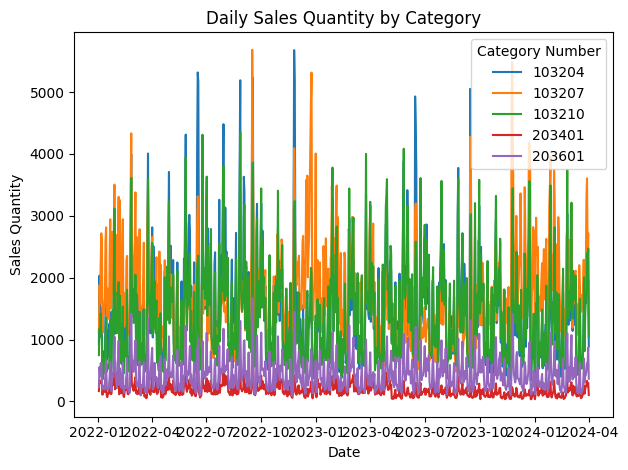

In [8]:
# Cell 3: Visualize Sales Trends for Categories
plt.figure(figsize=(15, 8))
df.groupby([df.index.date, 'category_no'])['sales_qty_base_uom'].sum().unstack().plot()
plt.title('Daily Sales Quantity by Category')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend(title='Category Number')
plt.tight_layout()
plt.show()

This graph shows the Daily Sales Quantity by Category over time, from early 2022 to April 2024. Here's what we can observe:

1. The data is broken down into five different categories, each represented by a different color and identified by a category number (103204, 103207, 103210, 203401, 203601).

2. Sales quantities are plotted on the y-axis, ranging from 0 to about 6000 units.

3. The x-axis represents time, spanning from January 2022 to April 2024.

4. There are clear differences in sales volumes between categories:
   - Category 103210 (green) seems to have the highest overall sales quantities.
   - Category 203601 (purple) appears to have the lowest sales quantities.

5. There are visible patterns and fluctuations in sales for all categories:
   - Some categories show more volatility than others.
   - There appear to be regular spikes and dips, which could indicate weekly or monthly patterns.

6. There's no clear overall upward or downward trend across all categories, suggesting relatively stable sales over the two-year period.

7. Some categories (like 103204 and 103207) show occasional very high spikes in sales, which could represent promotional events or seasonal peaks.

8. The graph is quite dense, indicating daily data points for each category over the entire period.

This visualization is useful for comparing sales performance across different product categories and identifying potential seasonal patterns or anomalies in sales data. It provides a high-level view of sales trends that can guide further, more detailed analysis.


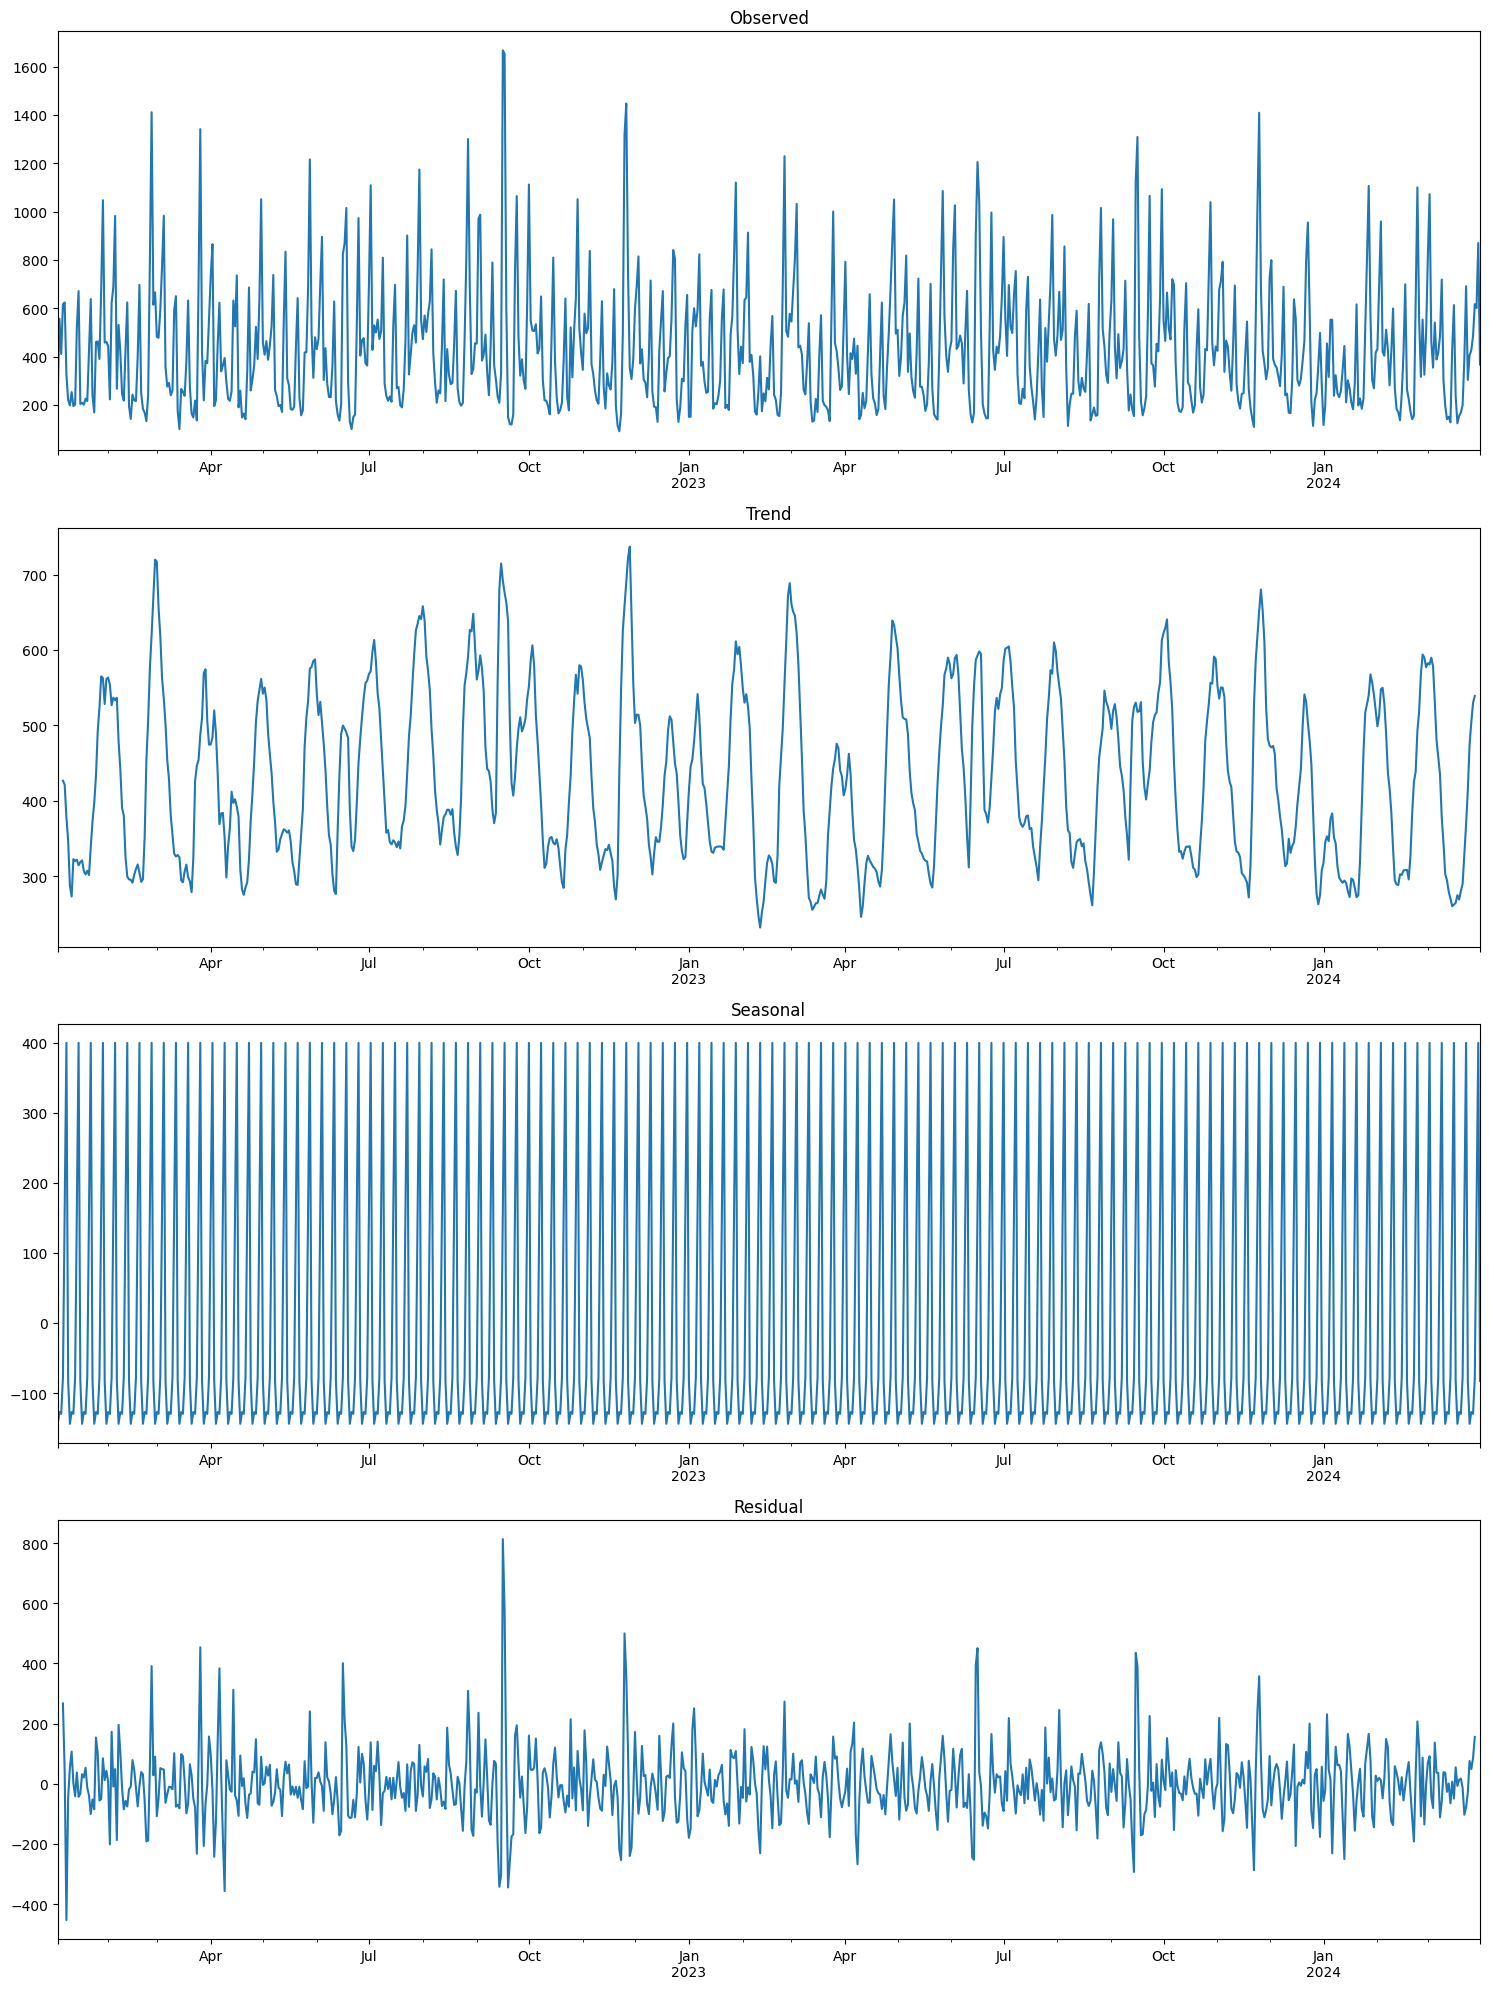

In [9]:
# Cell 4: Identify Seasonal Patterns (for category 203601)
category = df[df['category_no'] == 203601]
daily_sales = category.resample('D')['sales_qty_base_uom'].sum()

# Fill missing dates with 0 sales
daily_sales = daily_sales.reindex(pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max()), fill_value=0)

# Perform seasonal decomposition
result = seasonal_decompose(daily_sales, model='additive', period=7)  # assuming weekly seasonality

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))
result.observed.plot(ax=ax1)
ax1.set_title('Observed')
result.trend.plot(ax=ax2)
ax2.set_title('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

This image shows the results of a time series decomposition for sales data of category 203601. The decomposition breaks down the time series into four components:

1. **Observed:** This is the raw data, showing the actual daily sales quantities. The sales fluctuate between about 200 and 1600 units, with regular spikes and dips.

2. **Trend:** This component shows the overall direction of the data over time, removing short-term fluctuations. The trend line fluctuates between about 300 and 700 units, suggesting no strong long-term upward or downward trend, but rather cyclical patterns over several months.

3. **Seasonal:** This component reveals regular patterns that repeat at fixed intervals. The clear weekly pattern indicates higher sales on certain days of the week (likely weekends) and lower sales on others. This pattern is consistent throughout the entire period.

4. **Residual:** This shows what's left after removing the trend and seasonal components from the observed data. It represents random variations and potential anomalies. Most residuals are between -200 and 200 units, with occasional larger spikes that could indicate unusual events or outliers.

**Key insights:**
1. There's a strong weekly seasonality in sales for this category.
2. The overall trend shows fluctuations but no clear long-term growth or decline.
3. There are occasional large spikes in sales that aren't explained by the regular seasonal pattern, which could be due to promotions, holidays, or other special events.
4. The residual plot shows that the model captures most of the variation, but there are still some unexplained patterns, suggesting that additional factors might influence sales.

This decomposition is valuable for understanding the different factors affecting sales in this category and can help in forecasting future sales and planning inventory. It suggests that day-of-week effects are crucial, and that there might be longer-term cyclical patterns worth investigating further.

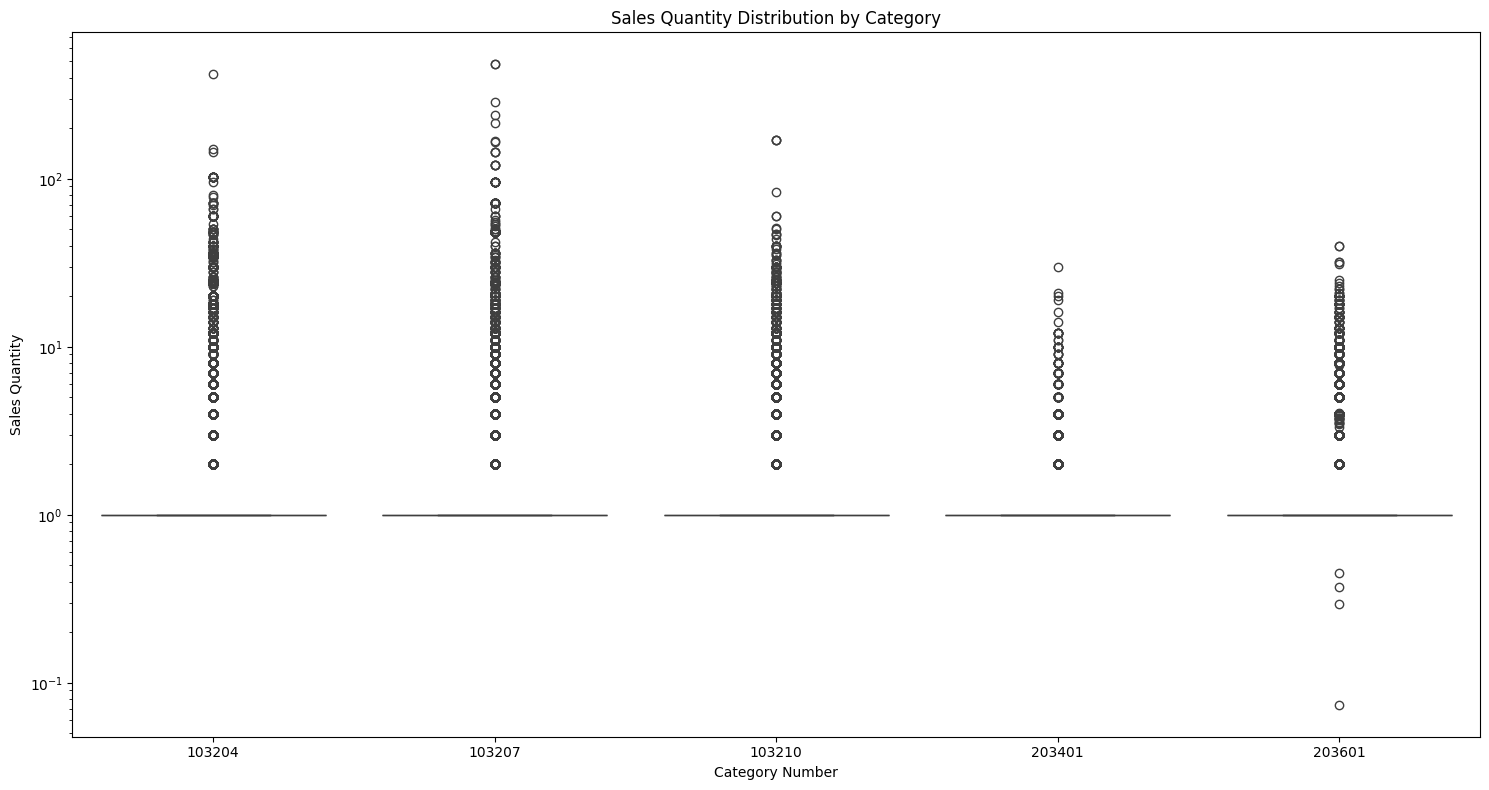

In [10]:
# Cell 5: Visualize Sales Quantity Distribution by Category (Box Plot)
plt.figure(figsize=(15, 8))
sns.boxplot(x='category_no', y='sales_qty_base_uom', data=df)
plt.title('Sales Quantity Distribution by Category')
plt.xlabel('Category Number')
plt.ylabel('Sales Quantity')
plt.yscale('log')  # Using log scale for better visualization
plt.tight_layout()
plt.show()

this plot flopped

## Feature Engineering

In [11]:
#Create time-based features
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week

In [12]:
#Calculate rolling averages
df['sales_qty_7day_avg'] = df.groupby('article_code')['sales_qty_base_uom'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['sales_qty_30day_avg'] = df.groupby('article_code')['sales_qty_base_uom'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

In [13]:
#Create lag features
df['sales_qty_lag1'] = df.groupby('article_code')['sales_qty_base_uom'].shift(1)
df['sales_qty_lag7'] = df.groupby('article_code')['sales_qty_base_uom'].shift(7)

In [14]:
#Derive features from article data
# Assuming 'article_desc' contains information about brand and category
df['brand'] = df['article_desc'].str.split().str[0]

In [15]:
# Create a price category based on the average price of the article
df['avg_price'] = df.groupby('article_code')['sales_qty_base_uom'].transform('mean')
df['price_category'] = pd.qcut(df['avg_price'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

In [17]:
df.head()

,date_key,unique_ticket_id,article_code,sales_qty_alternate_uom,alternate_uom,sales_qty_base_uom,base_uom_x,article_desc,base_uom_y,super_dept_no,...,month,day_of_month,week_of_year,sales_qty_7day_avg,sales_qty_30day_avg,sales_qty_lag1,sales_qty_lag7,brand,avg_price,price_category
ticket_end_time,,,,,,,,,,,,,,,,,,,,,
2022-01-03 08:09:12,20220103,c6b2b8c8-1b52-4375-b065-79e48933fab6,10164184,1.0,EA,1.0,EA,"SOFT DRNK TWIST 2L, GDILLA",EA,10,...,1.0,3.0,1,1.0,1.0,NaN,NaN,SOFT,1.101184,Low
2022-01-03 08:09:43,20220103,45bc7474-a244-4c5a-b5c1-584f8662d1f2,10722932,1.0,EA,1.0,EA,"ENERGY DRINK SCORE 500ML, PASSIONFRT",EA,10,...,1.0,3.0,1,1.0,1.0,NaN,NaN,ENERGY,1.114583,Medium
2022-01-03 08:09:59,20220103,150a9040-fb3b-4b4e-9170-17d8af09e725,10143154,1.0,EA,1.0,EA,WATER STILL BONAQUA 500ML,EA,10,...,1.0,3.0,1,1.0,1.0,NaN,NaN,WATER,1.172748,High
2022-01-03 08:11:10,20220103,175b9537-94ee-416d-9ccc-d17ddb2141d0,10722932,1.0,EA,1.0,EA,"ENERGY DRINK SCORE 500ML, PASSIONFRT",EA,10,...,1.0,3.0,1,1.0,1.0,1.0,NaN,ENERGY,1.114583,Medium
2022-01-03 08:17:49,20220103,1676c7fc-a26a-4f4c-8bb2-7a89386b81f5,10551096,3.0,EA,3.0,EA,COFFEE INSTNT NESCAFE GOLD 1.8G,EA,10,...,1.0,3.0,1,3.0,3.0,NaN,NaN,COFFEE,3.046997,Very High


#Feature engineering importance in this project

**Capturing Temporal Patterns:**

Time-based features (day of week, month, etc.) help capture cyclical patterns in the data. For retail sales, there are often weekly, monthly, or seasonal patterns that significantly impact sales. This allows models to learn and account for these recurring patterns, improving prediction accuracy.

**Incorporating Historical Information:**

Rolling averages and lag features provide historical context to the current data point. They help capture trends and autocorrelation in the time series, which are crucial for accurate forecasting.

**Enhancing Model Performance:**

Machine learning models, especially those that aren't specifically designed for time series (like random forests or gradient boosting machines), benefit greatly from these engineered features. They allow the models to capture complex temporal relationships that might not be apparent in the raw data.

**Dealing with Non-linear Relationships:**

Features like 'is_weekend' or 'price_category' can help capture non-linear relationships in the data. For example, sales behavior might be significantly different on weekends compared to weekdays.

**Incorporating Domain Knowledge:**

Deriving features from article data (like brand or price category) allows you to incorporate business-specific information into your models. This can lead to more interpretable and actionable insights.

**Dimensionality Reduction:**

While it might seem counterintuitive, adding more features can actually help in reducing dimensionality by capturing complex patterns in simpler terms. For example, a rolling average can summarize a lot of historical information in a single value.

**Handling Seasonality:**

Features like 'month' or 'week_of_year' help models account for seasonality without needing to use more complex seasonal decomposition techniques.

**Improving Interpretability:**

Engineered features often have clear business meanings (e.g., '7-day average sales'), making model outputs more interpretable to stakeholders.

**Preparing for Various Modeling Techniques:**

Different types of models may benefit from different types of features. By creating a rich set of features, you're preparing your data for various modeling approaches.

**Capturing External Factors:**

While not shown in this specific example, feature engineering also allows for the incorporation of external factors (like holidays, promotions, or economic indicators) that might influence sales.


In [21]:
df[['day_of_week', 'is_weekend', 'month', 'sales_qty_7day_avg', 'sales_qty_30day_avg', 'sales_qty_lag1', 'sales_qty_lag7']].describe()

,day_of_week,is_weekend,month,sales_qty_7day_avg,sales_qty_30day_avg,sales_qty_lag1,sales_qty_lag7
count,3.188241e+06,3.189239e+06,3.188241e+06,3.189239e+06,3.189239e+06,3.188092e+06,3.181267e+06
mean,3.285935e+00,3.379969e-01,6.067775e+00,1.327781e+00,1.327563e+00,1.327842e+00,1.327603e+00
std,1.887637e+00,4.730276e-01,3.550430e+00,8.827577e-01,7.691946e-01,1.442222e+00,1.440515e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,-6.000000e+00,-1.000000e+00,-7.200000e+01,-7.200000e+01
25%,2.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,1.033333e+00,1.000000e+00,1.000000e+00
50%,4.000000e+00,0.000000e+00,6.000000e+00,1.142857e+00,1.100000e+00,1.000000e+00,1.000000e+00
75%,5.000000e+00,1.000000e+00,9.000000e+00,1.285714e+00,1.266667e+00,1.000000e+00,1.000000e+00
max,6.000000e+00,1.000000e+00,1.200000e+01,7.914286e+01,2.653333e+01,4.800000e+02,4.800000e+02


In [20]:
# Display unique values in categorical features
print("Unique brands:", df['brand'].nunique())
print("Price categories:", df['price_category'].value_counts())

Unique brands: 82
Price categories: price_category
Medium       644294
Low          641801
Very Low     638625
Very High    637249
High         627270
Name: count, dtype: int64
